In [44]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from scipy.spatial import distance
from sklearn import manifold
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

import matplotlib.pyplot as plt

In [4]:
# bitovy vektor je tak velky, aby mel nejakou informacni hodnotu, tj, kdyby byl prilis kratky(napriklad 8), tak to budou same jednicky
supp = Chem.SDMolSupplier("../data/drugbank.sdf")
drugbank = [mol for mol in supp if mol]
fps = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 1024) for m in drugbank]

In [5]:
# jak vybrat co nejmene podobne struktury? (Zustane zachovana rozmanitost chemickeho prostoru)
# distancni matice, jaccard vzdalenost(1 - tanemoto)
sparseMat = distance.pdist(fps, metric = 'jaccard')

In [6]:
# ze sparse matice -> ctvercova
distMat = distance.squareform(sparseMat)

In [7]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity = "precomputed")
xMDS = clf.fit_transform(distMat)

In [8]:
# numpy objekt, prvni sloupec, druhy radek?
xMDS[0]

array([-0.30126781, -0.05643684])

In [9]:
xMDS[1, 0]

0.272496372015755

In [10]:
def MDSplot(_x, *args, highlights=set()):
    plt.figure()
    ax = plt.subplot(111)
    for i, point in enumerate (_x):
        x, y = point
        if i in highlights:
            plt.plot([x], [y], "r.", markersize = 4)
        else:
            plt.plot([x], [y],"k.", markersize = 1)
    plt.show()

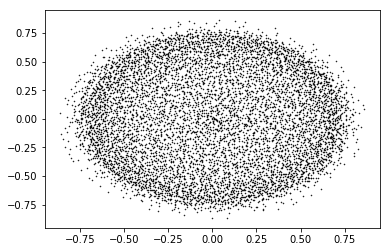

In [11]:
MDSplot(xMDS)

In [12]:
pattern = Chem.MolFromSmiles("c1ccccc1")


In [13]:
patIndeces = [i for i, mol in enumerate(drugbank) if mol.HasSubstructMatch(pattern)]

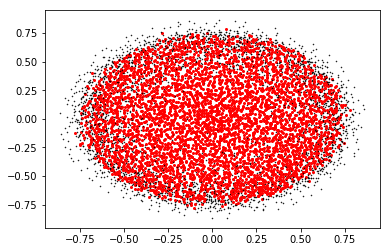

In [14]:
MDSplot(xMDS, highlights=set(patIndeces))

In [15]:
pattern2 = Chem.MolFromSmiles("OC(=O)c1ccccc1O")
patIndeces2 = [i for i, mol in enumerate(drugbank) if mol.HasSubstructMatch(pattern2)]

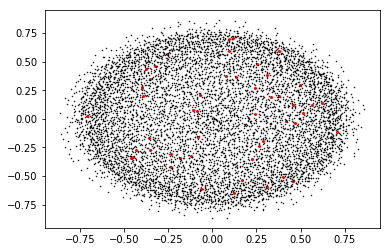

In [16]:
MDSplot(xMDS, highlights=set(patIndeces2))

In [17]:
distMat[patIndeces2,:][:,patIndeces2]

array([[0.        , 0.30769231, 0.90666667, ..., 0.83333333, 0.69565217,
        0.90322581],
       [0.30769231, 0.        , 0.90666667, ..., 0.84810127, 0.72340426,
        0.90322581],
       [0.90666667, 0.90666667, 0.        , ..., 0.83783784, 0.8988764 ,
        0.86021505],
       ...,
       [0.83333333, 0.84810127, 0.83783784, ..., 0.        , 0.84946237,
        0.89423077],
       [0.69565217, 0.72340426, 0.8988764 , ..., 0.84946237, 0.        ,
        0.89473684],
       [0.90322581, 0.90322581, 0.86021505, ..., 0.89423077, 0.89473684,
        0.        ]])

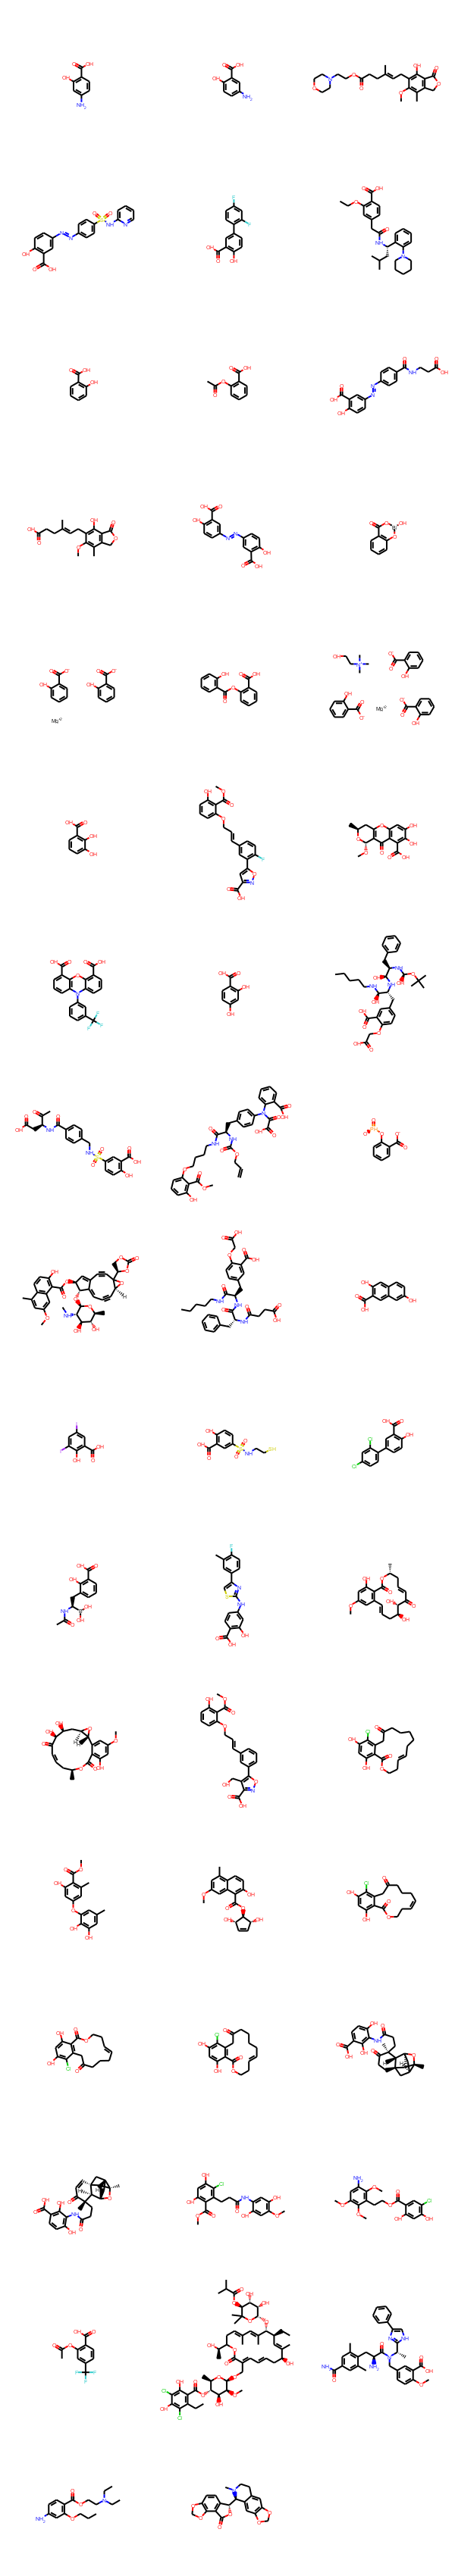

In [18]:
Draw.MolsToGridImage([mol for i, mol in enumerate(drugbank) if i in patIndeces2])

In [19]:
# jak moc jsou si podobne?
def distanceFunction(index1, index2, *args, matrix = distMat):    
    return matrix[index1, index2]

In [20]:
picker = MaxMinPicker()
pickedGenerator = picker.LazyPick(distanceFunction, len(drugbank), 100, seed = 666)

In [21]:
picked = set(pickedGenerator)


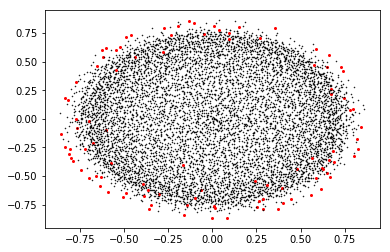

In [22]:
MDSplot(xMDS, highlights = picked)

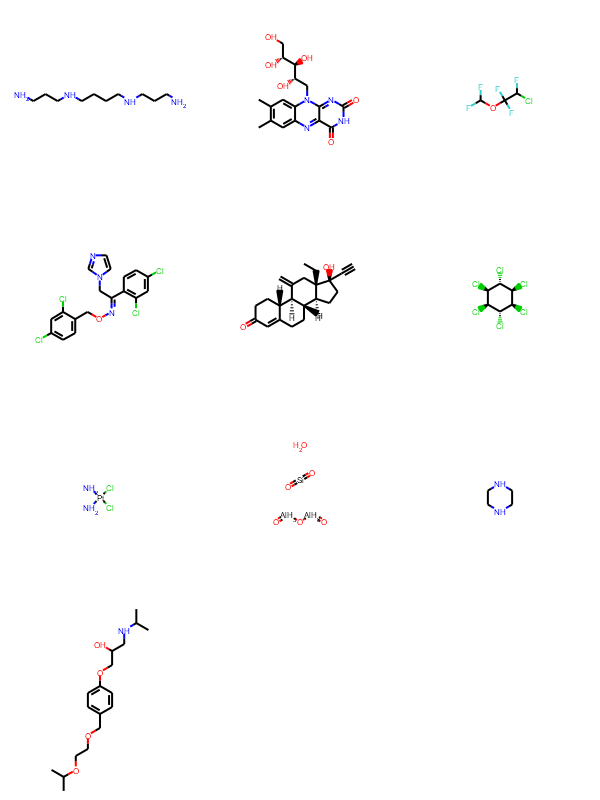

In [23]:
Draw.MolsToGridImage([mol for i, mol in enumerate(drugbank) if i in picked][:10])

In [24]:
# odstranit neorganicke struktury, kde neni uhlik neni organika
pattern3 = Chem.MolFromSmarts("[#6]")
patIndeces3 = [i for i, mol in enumerate(drugbank) if not mol.HasSubstructMatch(pattern3)]


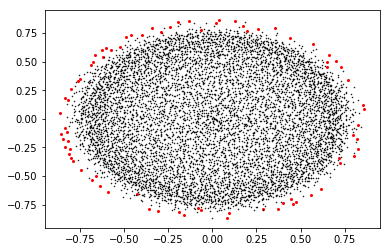

In [25]:
MDSplot(xMDS, highlights=set(patIndeces3))

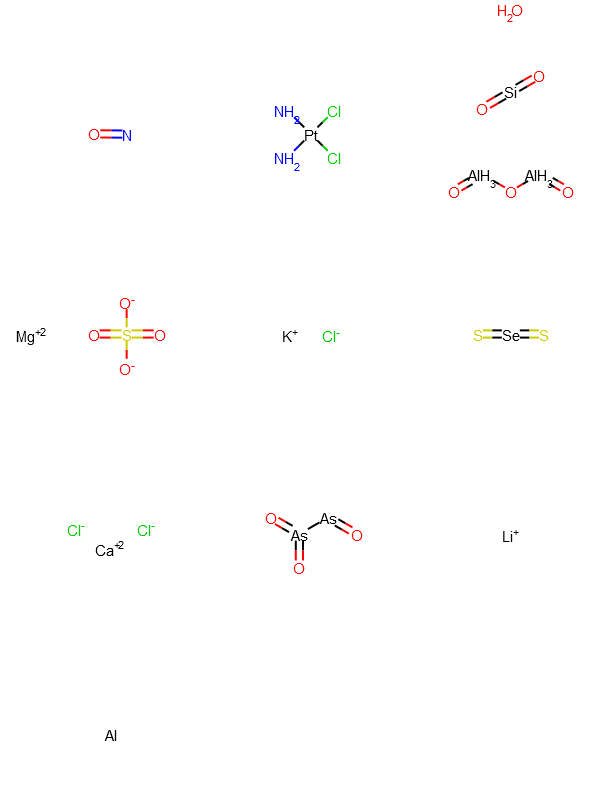

In [26]:
Draw.MolsToGridImage([mol for i, mol in enumerate(drugbank) if i in patIndeces3][:10])

In [80]:
len(patIndeces3)

79

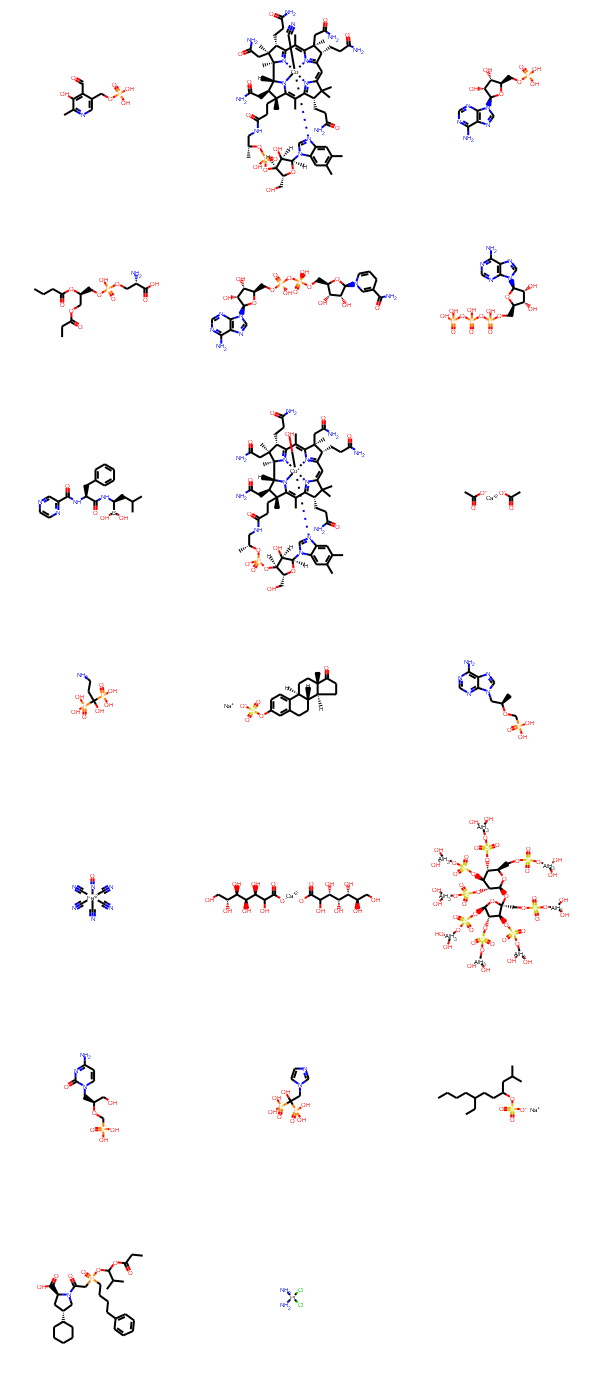

In [48]:
# non carbon pattern
pattern4 = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
patIndeces4 = [i for i, mol in enumerate(drugbank) if mol.HasSubstructMatch(pattern4)]
Draw.MolsToGridImage([mol for i, mol in enumerate(drugbank) if i in patIndeces4][:20])

In [64]:
remover = SaltRemover(defnData="[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")



In [57]:
[Chem.MolToSmiles(mol) for i, mol in enumerate(drugbank) if i in patIndeces4][:10]

['Cc1ncc(COP(=O)(O)O)c(C=O)c1O',
 'CC1=C2N3=C(C=C4N5=C(C(C)=C6N7C8C(CC(N)=O)C6(C)CCC(=O)NCC(C)OP(=O)(O)OC6C(CO)OC(C6O)n6cn(c9cc(C)c(C)cc96)~[Co]7~5~3(C#N)~N3=C1C(CCC(N)=O)C(C)(CC(N)=O)C83C)C(CCC(N)=O)C4(C)C)C(CCC(N)=O)C2(C)CC(N)=O',
 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)O)C(O)C1O',
 'CCCC(=O)OC(COC(=O)CC)COP(=O)(O)OCC(N)C(=O)O',
 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O',
 'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O',
 'CC1=C2N3=C(C=C4N5=C(C(C)=C6N7C8C(CC(N)=O)C6(C)CCC(=O)NCC(C)OP(=O)([O-])OC6C(CO)OC(C6O)n6cn(c9cc(C)c(C)cc96)~[Co+]7~5~3(O)~N3=C1C(CCC(N)=O)C(C)(CC(N)=O)C83C)C(CCC(N)=O)C4(C)C)C(CCC(N)=O)C2(C)CC(N)=O',
 'CC(=O)[O-].CC(=O)[O-].[Ca+2]',
 'NCCC(O)(P(=O)(O)O)P(=O)(O)O']

In [63]:
mol = Chem.MolFromSmiles("[K+].[Cl-]")
a = Chem.MolToSmiles(remover(mol))
print(a)

[Cl-]
